### Metrics used in white paper 

In [1]:
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.plots as plots

# open database use OpsimDatabase
opsdb = db.OpsimDatabase('../maf/baseline2018a.db')

# output
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)

## UniformityMetric

In [9]:
class UniformityMetric(metrics.BaseMetric):
    """Calculate how uniformly the observations are spaced in time.
    Returns a value between -1 and 1.
    A value of zero means the observations are perfectly uniform.
    Parameters
    ----------
    surveyLength : float, optional
        The overall duration of the survey. Default 10.
    """
    def __init__(self, mjdCol='observationStartMJD', units='',
                 surveyLength=10., **kwargs):
        """surveyLength = time span of survey (years) """
        self.mjdCol = mjdCol
        super(UniformityMetric, self).__init__(col=self.mjdCol, units=units, **kwargs)
        self.surveyLength = surveyLength

    def run(self, dataSlice, slicePoint=None):
        """"Calculate the survey uniformity.
        This is based on how a KS-test works: look at the cumulative distribution of observation dates,
        and compare to a perfectly uniform cumulative distribution.
        Perfectly uniform observations = 0, perfectly non-uniform = 1.
        Parameters
        ----------
        dataSlice : numpy.array
            Numpy structured array containing the data related to the visits provided by the slicer.
        slicePoint : dict, optional
            Dictionary containing information about the slicepoint currently active in the slicer.
        Returns
        -------
        float
            Uniformity of 'observationStartMJDCol'.
        """
        # If only one observation, there is no uniformity
        if dataSlice[self.mjdCol].size == 1:
            return 1
        # Scale dates to lie between 0 and 1, where 0 is the first observation date and 1 is surveyLength
        dates = (dataSlice[self.mjdCol] - dataSlice[self.mjdCol].min()) / \
                (self.surveyLength * 365.25)
        dates.sort()  # Just to be sure
        n_cum = np.arange(1, dates.size + 1) / float(dates.size)
        D_max = np.max(np.abs(n_cum - dates - dates[1]))
        return D_max


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "r" and night<900 for columns ['fieldDec', 'observationStartMJD', 'fieldRA']
Found 112526 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "r" and night<900" constraint now.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/hom

monopole: 0.809783  dipole: lon: -82.9481, lat: 1.88601, amp: 0.0361606
Plotting complete.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


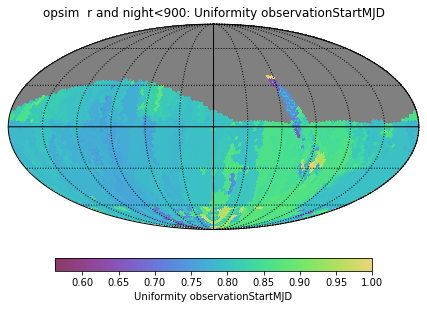

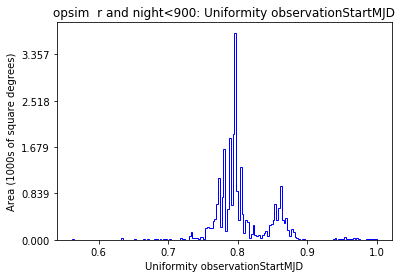

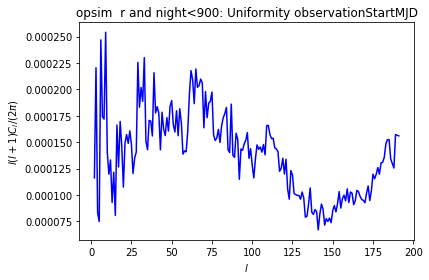

In [58]:
# Run the metric 
# metric, slicer, constraint
metric = UniformityMetric()
slicer = slicers.HealpixSlicer(nside = 64)
sqlconstraint = 'filter = "r" and night<900'

# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()
group.plotAll(closefigs = False)

## NRevisitsMetric

In [2]:
class NRevisitsMetric(metrics.BaseMetric):
    """Calculate the number of consecutive visits with time differences less than dT.
    Parameters
    ----------
    dT : float, optional
       The time interval to consider (in minutes). Default 30.
    normed : bool, optional
       Flag to indicate whether to return the total number of consecutive visits with time
       differences less than dT (False), or the fraction of overall visits (True).
       Note that we would expect (if all visits occur in pairs within dT) this fraction would be 0.5!
    """
    def __init__(self, mjdCol='observationStartMJD', dT=30.0, normed=False, metricName=None, **kwargs):
        units = ''
        if metricName is None:
            if normed:
                metricName = 'Fraction of revisits faster than %.1f minutes' % (dT)
            else:
                metricName = 'Number of revisits faster than %.1f minutes' % (dT)
                units = '#'
        self.mjdCol = mjdCol
        self.dT = dT / 60. / 24.  # convert to days
        self.normed = normed
        super(NRevisitsMetric, self).__init__(col=self.mjdCol, units=units, metricName=metricName, **kwargs)

    def run(self, dataSlice, slicePoint=None):
        """Count the number of consecutive visits occuring within time intervals dT.
        Parameters
        ----------
        dataSlice : numpy.array
            Numpy structured array containing the data related to the visits provided by the slicer.
        slicePoint : dict, optional
            Dictionary containing information about the slicepoint currently active in the slicer.
        Returns
        -------
        float
           Either the total number of consecutive visits within dT or the fraction compared to overall visits.
        """
        dtimes = np.diff(np.sort(dataSlice[self.mjdCol]))
        nFastRevisits = np.size(np.where(dtimes <= self.dT)[0])
        if self.normed:
            nFastRevisits = nFastRevisits / float(np.size(dataSlice[self.mjdCol]))
        return nFastRevisits


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint night<365 for columns ['fieldRA', 'fieldDec', 'observationStartMJD']
Found 227468 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night<365" constraint now.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/hom

monopole: 33.101  dipole: lon: 151.104, lat: -71.4928, amp: 10.2647
Plotting complete.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


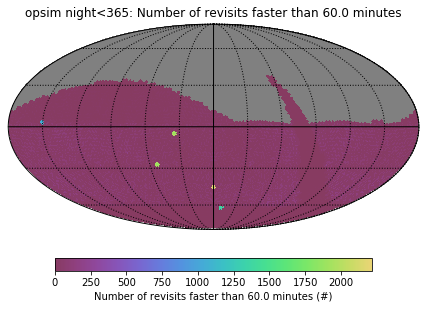

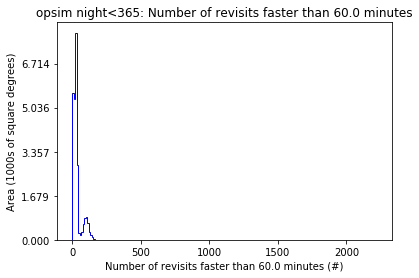

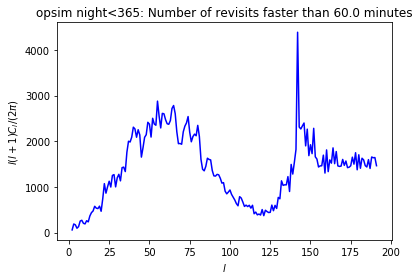

In [5]:
metric = NRevisitsMetric(dT=60)
slicer = slicers.HealpixSlicer(nside = 64)
sqlconstraint = 'night<365'

# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()
group.plotAll(closefigs = False)

## numObsInSurveyTimeOverlapMetric

In [31]:
from astropy.time import Time


class nObsInSurveyTimeOverlapMetric(metrics.BaseMetric):
    
    
    def __init__ (self, SurveyObsWin, TimeCol='observationStartMJD',metricName= 'numObsInSurveyTimeOverlap', **kwargs):
        
        self.TimeCol = TimeCol
        self.metricName = metricName
        self.SurveyObsWin = SurveyObsWin
        super().__init__(col= TimeCol, metricName=metricName, **kwargs)
        
    def run (self, dataSlice, slicePoint=None):
        N_Obs = 0
        for interval in self.SurveyObsWin :
            start_interval = Time(interval[0]+' 00:00:00')
            end_interval = Time(interval[1]+' 00:00:00')
            index = np.where ((dataSlice[self.TimeCol]> start_interval.mjd) & (dataSlice[self.TimeCol]<end_interval.mjd))[0]
            N_Obs = N_Obs + np.size(index)
        
        return N_Obs


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "r" and night<100 for columns ['fieldDec', 'observationStartMJD', 'fieldRA']
Found 8099 visits
Running:  ['Sky']


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.8.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:446: RuntimeWarning: invalid value encountered in equal
  b.metricValues.mask = np.where(b.metricValues.data == b.metric.badval,


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "r" and night<100" constraint now.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/hom

monopole: 0  dipole: lon: 0, lat: nan, amp: 0
Plotting complete.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


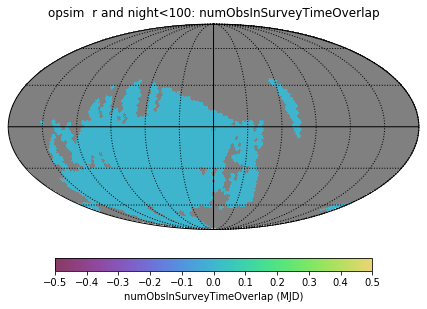

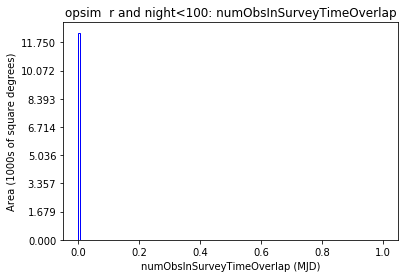

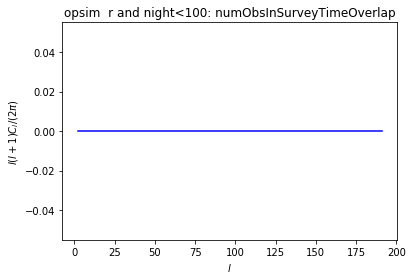

In [36]:
##[ [YYYY-MM-DD, YYYY-MM-DD] , [YYYY-MM-DD, YYYY-MM-DD] , ... , [YYYY-MM-DD, YYYY-MM-DD] ]
SurveyObsWin = [['2019-06-05','2020-06-05']]

metric = nObsInSurveyTimeOverlapMetric(SurveyObsWin)
slicer = slicers.HealpixSlicer(nside = 64)
sqlconstraint = 'filter = "r" and night<100'

# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()

group.plotAll(closefigs = False)

## IntervalsBetweenObsMetric

In [66]:
# Calculates statistics (mean or median or standard deviation) of intervals between observations during simultaneous windows/Inter-seasonal gap of another survey.
# SurveyIntervals is the list of the survey observing window/Inter-seasonal gap intervals. It should be in the format:
# SurveyIntervals = [ [YYYY-MM-DD, YYYY-MM-DD] , [YYYY-MM-DD, YYYY-MM-DD] , ... , [YYYY-MM-DD, YYYY-MM-DD] ]
# We are interested in calculating this metric in each of the LSST passbands.
# The difference between this metric and the VisitGapMetric metric is that VisitGapMetric calculates reduceFunc of gaps between observations of a dataslice throughout the whole 
# baseline, but IntervalsBetweenObsMetric calculates the gaps between observations during another survey observing window. This metric combined with surveys footprint
# overlap can determine how many often another survey footprint is observed by LSST during specific time intervals.

from astropy.time import Time

class IntervalsBetweenObs(metrics.BaseMetric):
    

    
    def __init__ (self, SurveyIntervals, Stat, metricName= 'IntervalsBetweenObs', TimeCol='observationStartMJD', **kwargs):
        
        self.TimeCol = TimeCol
        self.metricName = metricName
        self.SurveyIntervals = SurveyIntervals
        self.Stat = Stat
        super(IntervalsBetweenObs, self).__init__(col= TimeCol, metricName=metricName, **kwargs)


    def run (self, dataSlice, slicePoint=None):

        
        dataSlice.sort(order=self.TimeCol)
        obs_diff = []
        
        for interval in self.SurveyIntervals :
            
            start_interval = Time(interval[0]+' 00:00:00')
            end_interval = Time(interval[1]+' 00:00:00')
            index = dataSlice[self.TimeCol][np.where ((dataSlice[self.TimeCol]> start_interval.mjd) & (dataSlice[self.TimeCol]<end_interval.mjd))[0]]
            obs_diff_per_interval = np.diff(index) 
            obs_diff = obs_diff + obs_diff_per_interval.tolist()
            
        if self.Stat == 'mean':
            result = np.mean(obs_diff)
        
        elif self.Stat =='median' :
            result = np.median(obs_diff)
        
        elif self.Stat == 'std' : 
            result = np.std(obs_diff)  

        return result

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Querying database SummaryAllProps with constraint filter = "r" and night<300 for columns ['fieldDec', 'observationStartMJD', 'fieldRA']
Found 35602 visits
Running:  ['Sky']


/home/docmaf/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/docmaf/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.8.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:446: RuntimeWarning: invalid value encountered in equal
  b.metricValues.mask = np.where(b.metricValues.data == b.metric.badval,


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "r" and night<300" constraint now.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1027: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:105

Plotting complete.


/home/docmaf/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_maf/2.8.0.sims/python/lsst/sims/maf/metricBundles/metricBundleGroup.py:583: UserWarning: Plotting failed for metricBundle opsim_IntervalsBetweenObs_r_and_nightlt300_HEAL. Error message: zero-size array to reduction operation minimum which has no identity
  warnings.warn(message)


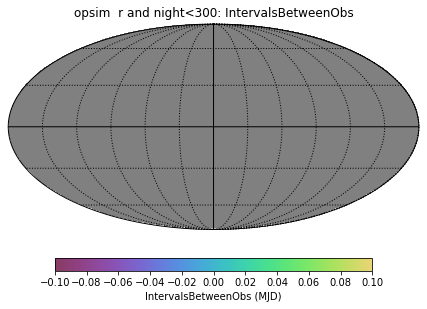

In [68]:

SurveyIntervals = [['2019-06-05','2020-06-05']]

Stat = 'mean'

metric = IntervalsBetweenObs(SurveyIntervals, Stat)
slicer = slicers.HealpixSlicer(nside = 32)
sqlconstraint = 'filter = "r" and night<300'

# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()
group.plotAll(closefigs = False)

## EventTrigerMetric

In [41]:
class EventTriggerMetric(metrics.BaseMetric):
    """
    For three observations separated by a minimum time frame, and all occurring within a maximum time frame
    """
    def __init__(self, TimeCol='observationStartMJD', **kwargs):
        self.TimeCol=TimeCol
        self.delmin=kwargs.pop('DelMin', 1)/24. #hours to days
        self.delmax=kwargs.pop('DelMax', 48)/24. #hours to days
        super(EventTriggerMetric, self).__init__(col=[self.TimeCol], **kwargs)

    def run(self, dataSlice, slicePoint=None):
        # start and end of all observations in OpSim run, not just for this point in sky
        obs_start=59580.
        obs_end=63230.
        times=np.asarray(dataSlice[self.TimeCol])
        times=np.sort(times)
        # create start times for all test windows
        testwindows=np.arange(obs_start, obs_end-self.delmax, self.delmin/4.)
        valid=0
        # iterate over all test windows and check if criteria is satisfied
        for timestart in testwindows:
            time_trim=times[(times >= timestart) & (times <= timestart+self.delmax)]
            if time_trim.size > 3:
                time_trim2=time_trim[(time_trim >= time_trim[0]+self.delmin) & (time_trim <= time_trim[-1]-self.delmin)]
                if time_trim2.size > 1:
                    valid=valid+1

        #print valid, testwindows.size
        return valid/(1.*testwindows.size)

    def reduceFraction(self, data):
        return data


In [59]:
metric = EventTriggerMetric()
slicer = slicers.HealpixSlicer(nside = 32)
sqlconstraint = 'filter = "r" and night<50'

# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()
group.plotAll(closefigs = False)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Querying database SummaryAllProps with constraint filter = "r" and night<50 for columns ['fieldDec', 'observationStartMJD', 'fieldRA']
Found 2764 visits
Running:  ['Sky']


KeyboardInterrupt: 

## CampaignLengthMetric

In [11]:
class CampaignLengthMetric(metrics.BaseMetric):
    """The campaign length, in seasons. 
    In the main survey this is 
    typically 10 or 11, depending on when the start of the survey 
    was relative to that sky position's season. For lensed quasar time
    delays we want the campaign to be as long as possible, although 
    we'd probably trade campaign length for higher cadence or season 
    length.
    
    Units: none (it's an integer number of seasons)
    
    Used by: LensedQuasarTimeDelays, ...
    """
    def __init__(self, seasonCol='season', **kwargs):
        """
        seasonCol = the name of the column defining the season number
        """
        self.seasonCol = seasonCol
        super(CampaignLengthMetric, self).__init__(col=[self.seasonCol], **kwargs)

    def run(self, dataSlice, slicePoint=None):
        # Count the seasons:
        seasons = np.unique(dataSlice[self.seasonCol])
        count = len(seasons)
        # print "seasons, count:",seasons,count
        return count


In [ ]:
# Run the metric 
# metric, slicer, constraint
metric = UniformityMetric()
slicer = slicers.HealpixSlicer(nside = 64)
sqlconstraint = 'filter = "r" and night<100'

# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()
group.plotAll(closefigs = False)